# unsegmented input - segmented output experiments

## Experimental setup

* dataset: Hungarian Webcorpus segmented using the output of HuNLP-Gate
  * segmentation converted to standoff tagging using two tags: B (beginning morpheme), E (continuation of morpheme)
* architecture: bucketed embedding seq2seq with a single LSTM/GRU layer
* 50000 unique words-segmentation pairs were used
  * 80-10-10 train-valid-test split
* fixed parameters: `batch_size`=1000
* varying parameters uniformly sampled from these ranges:
 
| Parameter | Range |
| --- | --- |
| cell type | `['LSTM', 'GRU']` |
| cell size | `[16, 32, 64, 128, 256, 512]` | 
| embedding size | `[i*5 for i in range(1, 11)]` |
| early stopping patience | `[1, 5, 10]` |
| early stopping threshold | `[1e-2, 1e-3, 1e-4]' |

### Misc

* only one bucket is used, the input is filtered to max 20 character long words, that's also the bucket size
  * multiple bucket support is not (completely) implemented

In [1]:
import pandas as pd
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.pyplot.rcParams['figure.figsize'] = (10, 7)
matplotlib.pyplot.rcParams['font.family'] = 'sans-serif'

In [2]:
df = pd.read_table('../results/space_segmented_1M.tsv')

In [3]:
def extract_last_if_list(text):
    if isinstance(text, str):
        val = eval(text)
    else:
        val = text
    if isinstance(val, list):
        return val[-1]
    return val

df['result.last_val_loss'] = df['result.val_loss'].apply(extract_last_if_list)
df['result.last_train_loss'] = df['result.train_loss'].apply(extract_last_if_list)
df['result.last_test_loss'] = df['result.test_loss'].apply(extract_last_if_list)

# General

In [4]:
df.describe()

,conf.cell_size,conf.embedding_size,conf.patience,conf.val_loss_th,data.length_limit,result.epochs_run,result.patience,result.running_time,result.val_loss_th,result.last_val_loss,result.last_train_loss,result.last_test_loss
count,189.000000,189.000000,189.000000,189.000000,189.0,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,161.185185,25.793651,5.507937,0.004143,20.0,1153.878307,5.507937,214.305134,0.004143,1.196211,1.198011,1.194154
std,167.333889,14.063109,3.607939,0.004569,0.0,2202.337158,3.607939,579.359669,0.004569,0.861203,0.862341,0.859743
min,16.000000,5.000000,1.000000,0.000100,20.0,8.000000,1.000000,1.731902,0.000100,0.046378,0.019693,0.043548
25%,32.000000,15.000000,1.000000,0.000100,20.0,55.000000,1.000000,6.059928,0.000100,0.182074,0.180176,0.182839
50%,128.000000,25.000000,5.000000,0.001000,20.0,121.000000,5.000000,30.691847,0.001000,1.618442,1.619245,1.613796
75%,256.000000,40.000000,10.000000,0.010000,20.0,1046.000000,10.000000,186.434445,0.010000,1.840546,1.840031,1.837884
max,512.000000,50.000000,10.000000,0.010000,20.0,10000.000000,10.000000,5184.865827,0.010000,2.715188,2.726181,2.711479


# Helper variables

In [5]:
parameters = ['conf.patience', 'conf.val_loss_th', 'conf.cell_size', 'conf.cell_type', 'conf.embedding_size']
result_columns = ['result.epochs_run', 'result.last_test_loss', 'result.last_val_loss', 'result.last_train_loss']

# Best configs

In [6]:
df.sort_values('result.test_loss').head(10)[parameters + result_columns]

,conf.patience,conf.val_loss_th,conf.cell_size,conf.cell_type,conf.embedding_size,result.epochs_run,result.last_test_loss,result.last_val_loss,result.last_train_loss
136,10.0,0.0001,256.0,GRU,15.0,10000.0,0.043548,0.046378,0.023715
66,10.0,0.0001,512.0,LSTM,35.0,10000.0,0.044477,0.047533,0.019693
168,10.0,0.0001,512.0,GRU,5.0,10000.0,0.047330,0.048326,0.026168
133,10.0,0.0001,128.0,GRU,30.0,5498.0,0.050630,0.054939,0.048013
68,10.0,0.0001,256.0,LSTM,35.0,5592.0,0.060352,0.063422,0.052666
47,5.0,0.0001,512.0,GRU,40.0,2602.0,0.067386,0.065799,0.057615
13,5.0,0.0001,512.0,LSTM,25.0,3026.0,0.068532,0.072635,0.069221
157,10.0,0.0001,256.0,GRU,15.0,3123.0,0.068628,0.065632,0.059894
121,5.0,0.0001,256.0,GRU,35.0,1949.0,0.075428,0.074534,0.077338
4,5.0,0.0001,256.0,GRU,20.0,1728.0,0.077336,0.077633,0.079735


# Embedding size

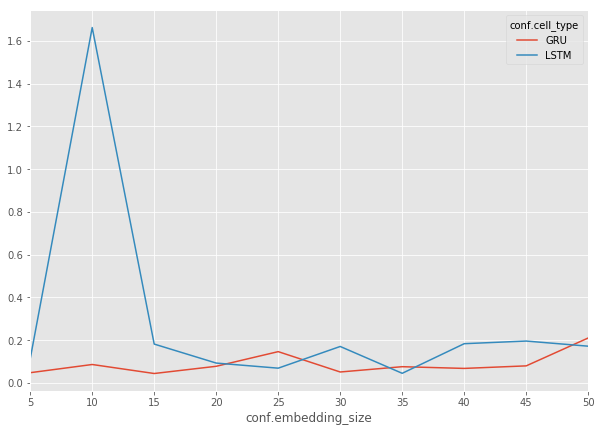

In [7]:
r = df.groupby(['conf.embedding_size', 'conf.cell_type'])['result.last_test_loss'].min().unstack('conf.cell_type')
r.plot()

# Cell size

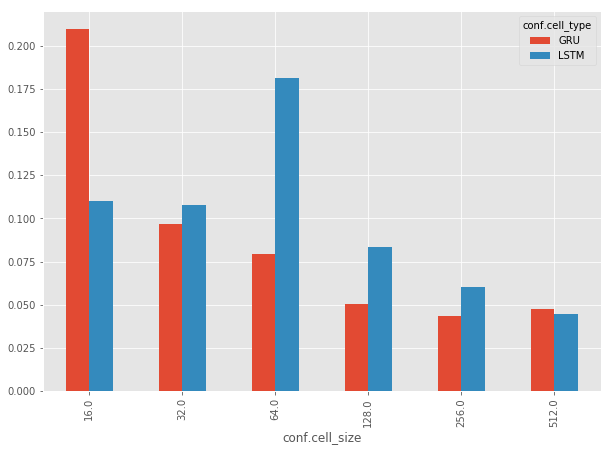

In [8]:
r = df.groupby(['conf.cell_size', 'conf.cell_type'])['result.last_test_loss'].min().unstack('conf.cell_type')
r.plot(kind='bar')

# Early stopping threshold and patience

In [9]:
df.groupby(['conf.val_loss_th', 'conf.patience'])['result.last_test_loss'].min().to_frame()

result.last_test_loss
conf.val_loss_th conf.patience                       
0.0001           1.0                         0.252728
                 5.0                         0.067386
                 10.0                        0.043548
0.0010           1.0                         1.708547
                 5.0                         0.147659
                 10.0                        0.134648
0.0100           1.0                         1.931489
                 5.0                         1.560569
                 10.0                        1.431593

In [10]:
d = df.iloc[df.groupby(['conf.val_loss_th', 'conf.patience'])['result.last_test_loss'].idxmin()]
d[['result.running_time'] + parameters + result_columns]

,result.running_time,conf.patience,conf.val_loss_th,conf.cell_size,conf.cell_type,conf.embedding_size,result.epochs_run,result.last_test_loss,result.last_val_loss,result.last_train_loss
149,233.889413,1.0,0.0001,256.0,LSTM,15.0,879.0,0.252728,0.243540,0.253017
47,1198.882157,5.0,0.0001,512.0,GRU,40.0,2602.0,0.067386,0.065799,0.057615
136,2503.243705,10.0,0.0001,256.0,GRU,15.0,10000.0,0.043548,0.046378,0.023715
139,47.406812,1.0,0.0010,512.0,LSTM,20.0,91.0,1.708547,1.703775,1.703594
30,284.189429,5.0,0.0010,512.0,GRU,40.0,615.0,0.147659,0.149345,0.142947
188,234.189084,10.0,0.0010,256.0,GRU,35.0,911.0,0.134648,0.133762,0.133623
143,5.961102,1.0,0.0100,128.0,GRU,15.0,32.0,1.931489,1.928674,1.880807
98,50.102409,5.0,0.0100,512.0,GRU,20.0,107.0,1.560569,1.570811,1.555430
28,35.637253,10.0,0.0100,256.0,GRU,35.0,134.0,1.431593,1.445830,1.475525


# Early stopping - how early?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6955089ef0>]], dtype=object)

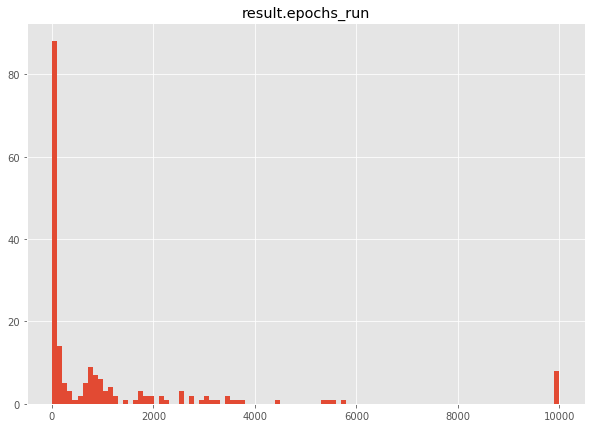

In [11]:
df.hist('result.epochs_run', bins=100)

In [12]:
df['result.epochs_run'].describe()

count      189.000000
mean      1153.878307
std       2202.337158
min          8.000000
25%         55.000000
50%        121.000000
75%       1046.000000
max      10000.000000
Name: result.epochs_run, dtype: float64